# Tendency budgets in regridded vertical coordinates

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
from xhistogram.xarray import histogram
import numpy as np

In [2]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/'
filename_native = '08990101.ocean_daily.nc'
filename_rho2 = '08990101.ocean_daily_rho2.nc'
filename_grid = '08990101.ocean_static_no_mask_table.nc'
ds_native = xr.open_dataset(rootdir+filename_native,decode_times=False)
ds_rho2 = xr.open_dataset(rootdir+filename_rho2,decode_times=False)
grid = xr.open_dataset(rootdir+filename_grid)

In [4]:
# Calculate the budgets, evaluate errors, merge to datasets
terms = ['T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','internal_heat_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
tend = 'opottemptend'
# Native
tendsum_native,error_native = bc.calc_budget(ds_native,terms,tend,vertc='zl',plot=False)
tendsum_native.name = 'tendsum'
error_native.name = 'error'
ds_native = xr.merge([ds_native,tendsum_native,error_native])
# Diagnostic
tendsum_rho2,error_rho2 = bc.calc_budget(ds_rho2,terms,tend,vertc='rho2_l',plot=False)
tendsum_rho2.name = 'tendsum'
error_rho2.name = 'error'
ds_rho2 = xr.merge([ds_rho2,tendsum_rho2,error_rho2])

### Compare budget closure in native and diagnostic grids
#### What is being plotted?  
##### Figure 1.  
**(left panel)** The vertical cumulative integral of (red) the eulerian tendencies and (blue) the sum of the individual tendencies from (.) the native grid (multiplied by -1) and (x) the diagnostic grid. **(middle panel)** The vertical cumulative integral (surface to bottom) of the budget "error" (eulerian tendency minus sum of individual tendencies). This is plotted against vertical cumulative integral (surface to bottom) of layer thickess, i.e. depth (when single profile) or volume (when global integral is taken). It is plotted for the native grid budget (blue), the diagnostic grid budget (orange), and the diagnostic grid budget linearly interpolated onto the "depth/volume" (cumulative thickness integral) of the native grid (green). **(right panel)** The difference between the native grid budget and the diagnostic grid budget.  
##### Figure 2.
The difference between the native grid and diagnostic grid for each of the budget terms (including the eulerian tendency). The difference for each term sums up to the total misfit from Figure 1 (as confirmed in the panel on the right).
#### What does it show?
For a single profile, the budget looks close to being close, with slight errors emerging in the surface that effectively cancel out. That is to say, there is a mis-apportioning of the tendencies between layers, such that cumulative error is zero (constrained to be such by interpolation procedure). The source of this error in the profile considered appears to be through the misplacement of the eulerian tendency, the advective tendency and the vertical remap tendency.

These (apparently small) errors in individual profiles accumulate in the global layer-wise integral, with the misfit arising from several different terms.

#### Single profile

In [36]:
# Reduce to single profile, either by selecting one, or by integrating in x and y
integrated = False
if integrated:
    prof_native = (ds_native*grid.areacello).sum(dim=['xh','yh']).squeeze()
    prof_rho2 = (ds_rho2*grid.areacello).sum(dim=['xh','yh']).squeeze()
else:
    prof_native = ds_native.sel(xh=-200,yh=20,method='nearest').squeeze()
    prof_rho2 = ds_rho2.sel(xh=-200,yh=20,method='nearest').squeeze()

In [37]:
# Calculate cumulative sums in vertical dimension for all dataset
prof_intz_native = prof_native.cumsum(dim='zl')
# Keep only non-zero thickness layers in diagnostic grid
prof_intz_rho2 = prof_rho2.cumsum(dim='rho2_l').where(prof_rho2.thkcello!=0,drop=True)
# Create a dataset with diagnostic grid interpolated onto native grid
# Make cumulative thickness the vertical coordinate, then interpolate onto cumulative thickness of native grid
prof_intz_rho2_on_native = prof_intz_rho2.assign_coords(rho2_l=prof_intz_rho2.thkcello).interp(rho2_l=prof_intz_native.thkcello,method='linear')

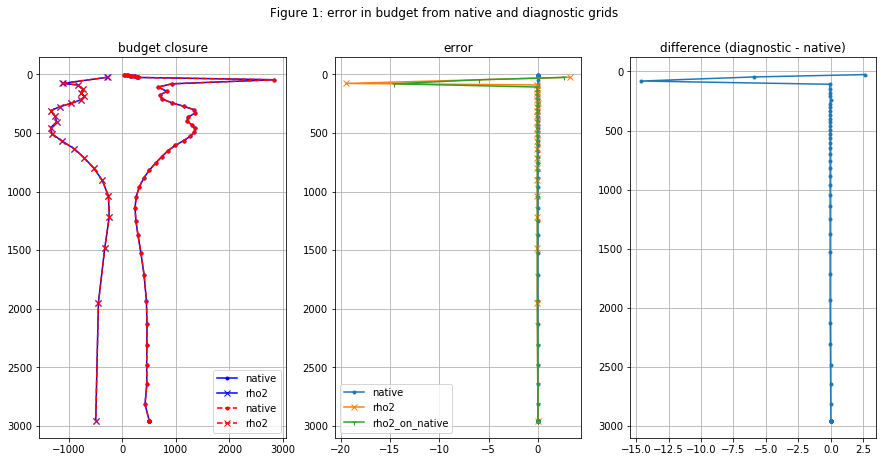

In [41]:
fig, ax = plt.subplots(figsize=(15,7),ncols=3)
fig.suptitle('Figure 1: error in budget from native and diagnostic grids')
# Plot the variable from the native grid, from the diagnostic grid,
# and from the diagnostic grid interpolated onto the native grid
var='tendsum'
ax[0].plot(-prof_intz_native[var],prof_intz_native.thkcello,color='b',marker='.',label='native')
ax[0].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,color='b',marker='x',label='rho2')

var=tend
ax[0].plot(-prof_intz_native[var],prof_intz_native.thkcello,color='r',marker='.',linestyle='--',label='native')
ax[0].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,color='r',marker='x',linestyle='--',label='rho2')
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend()
ax[0].set_title('budget closure')

var='error'
ax[1].plot(prof_intz_native[var],prof_intz_native.thkcello,marker='.',label='native')
ax[1].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,marker='x',label='rho2')
ax[1].plot(prof_intz_rho2_on_native[var],prof_intz_rho2_on_native.thkcello,marker='1',label='rho2_on_native')
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title(var)

ax[2].plot(prof_intz_rho2_on_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='.')
ax[2].invert_yaxis()
ax[2].grid()
ax[2].set_title('difference (diagnostic - native)');

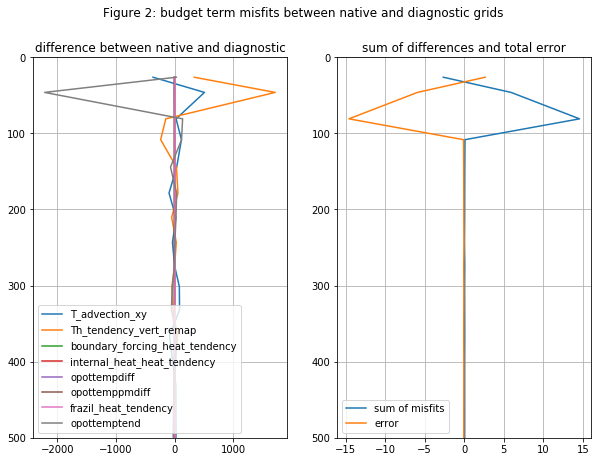

In [42]:
# Determine which terms the difference comes from
fig,ax = plt.subplots(figsize=(10,7),ncols=2)
fig.suptitle('Figure 2: budget term misfits between native and diagnostic grids')
diff_tot = np.zeros(shape=prof_intz_native.zl.values.shape)
for var in terms+[tend]:
    if var==tend:
        sign = -1
    else:
        sign=1
    diff = prof_intz_rho2_on_native[var].values-prof_intz_native[var].values
    ax[0].plot(sign*diff,prof_intz_native.thkcello,label=var)
    diff_tot += sign*diff
ax[0].set_ylim([0,500])
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend(loc='lower left')
ax[0].set_title('difference between native and diagnostic')

ax[1].plot(diff_tot,prof_intz_native.thkcello,label='sum of misfits')
ax[1].plot(prof_intz_rho2_on_native['error'],prof_intz_native.thkcello,label='error')
ax[1].set_ylim([0,500])
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title('sum of differences and total error');

#### Global layer-wise integral
Note that here, the y-axis can't be interpreted as "depth". Rather it is the volume of the ocean occupied by each layer, organised as a cumulative integral (top to bottom). This is a fair comparison between the two grids as it is evaluating the extent to which the budget is closed over an equivalent volume of the ocean, even if the volume does not occupy the exact same space (just as in the case for depth).

In [43]:
# Reduce to single profile, either by selecting one, or by integrating in x and y
integrated = True
if integrated:
    prof_native = (ds_native*grid.areacello).sum(dim=['xh','yh']).squeeze()
    prof_rho2 = (ds_rho2*grid.areacello).sum(dim=['xh','yh']).squeeze()
else:
    prof_native = ds_native.sel(xh=-200,yh=20,method='nearest').squeeze()
    prof_rho2 = ds_rho2.sel(xh=-200,yh=20,method='nearest').squeeze()

In [44]:
# Calculate cumulative sums in vertical dimension for all dataset
prof_intz_native = prof_native.cumsum(dim='zl')
# Keep only non-zero thickness layers in diagnostic grid
prof_intz_rho2 = prof_rho2.cumsum(dim='rho2_l').where(prof_rho2.thkcello!=0,drop=True)
# Create a dataset with diagnostic grid interpolated onto native grid
# Make cumulative thickness the vertical coordinate, then interpolate onto cumulative thickness of native grid
prof_intz_rho2_on_native = prof_intz_rho2.assign_coords(rho2_l=prof_intz_rho2.thkcello).interp(rho2_l=prof_intz_native.thkcello,method='linear')

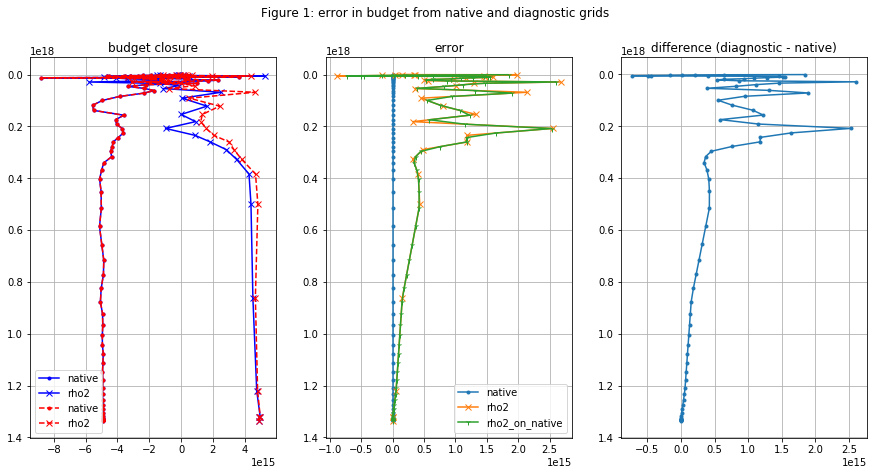

In [45]:
fig, ax = plt.subplots(figsize=(15,7),ncols=3)
fig.suptitle('Figure 1: error in budget from native and diagnostic grids')
# Plot the variable from the native grid, from the diagnostic grid,
# and from the diagnostic grid interpolated onto the native grid
var='tendsum'
ax[0].plot(-prof_intz_native[var],prof_intz_native.thkcello,color='b',marker='.',label='native')
ax[0].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,color='b',marker='x',label='rho2')

var=tend
ax[0].plot(-prof_intz_native[var],prof_intz_native.thkcello,color='r',marker='.',linestyle='--',label='native')
ax[0].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,color='r',marker='x',linestyle='--',label='rho2')
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend()
ax[0].set_title('budget closure')

var='error'
ax[1].plot(prof_intz_native[var],prof_intz_native.thkcello,marker='.',label='native')
ax[1].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,marker='x',label='rho2')
ax[1].plot(prof_intz_rho2_on_native[var],prof_intz_rho2_on_native.thkcello,marker='1',label='rho2_on_native')
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title(var)

ax[2].plot(prof_intz_rho2_on_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='.')
ax[2].invert_yaxis()
ax[2].grid()
ax[2].set_title('difference (diagnostic - native)');

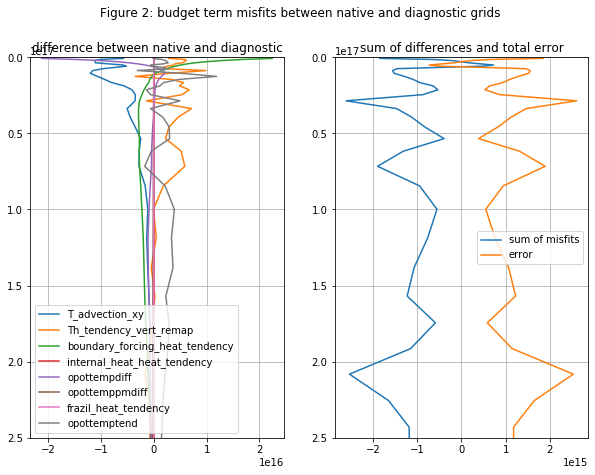

In [47]:
# Determine which terms the difference comes from
ylim=0.25E18
fig,ax = plt.subplots(figsize=(10,7),ncols=2)
fig.suptitle('Figure 2: budget term misfits between native and diagnostic grids')
diff_tot = np.zeros(shape=prof_intz_native.zl.values.shape)
for var in terms+[tend]:
    if var==tend:
        sign = -1
    else:
        sign=1
    diff = prof_intz_rho2_on_native[var].values-prof_intz_native[var].values
    ax[0].plot(sign*diff,prof_intz_native.thkcello,label=var)
    diff_tot += sign*diff
ax[0].set_ylim([0,ylim])
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend(loc='lower left')
ax[0].set_title('difference between native and diagnostic')

ax[1].plot(diff_tot,prof_intz_native.thkcello,label='sum of misfits')
ax[1].plot(prof_intz_rho2_on_native['error'],prof_intz_native.thkcello,label='error')
ax[1].set_ylim([0,ylim])
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title('sum of differences and total error');